## learning-AI101 : glass regression (DL)
### 유리 데이터를 Dense layer struction을 통한 DNN 방식 및 CNN으로의 regression

<br>

- **임규연 (lky473736)**
- 2024.08.04. ~ 2024.08.05. 문서 작성
- **dataset** : https://archive.ics.uci.edu/dataset/42/glass+identification
- **kaggle** : https://www.kaggle.com/datasets/uciml/glass
- **data abstract** : Vina conducted a comparison test of her rule-based system, BEAGLE, the nearest-neighbor algorithm, and discriminant analysis.  BEAGLE is a product available through VRS Consulting, Inc.; 4676 Admiralty Way, Suite 206; Marina Del Ray, CA 90292 (213) 827-7890 and FAX: -3189. In determining whether the glass was a type of "float" glass or not. The study of classification of types of glass was motivated by criminological investigation.  At the scene of the crime, the glass left can be used as evidence...if it is correctly identified!

------



## <span id='dl'><mark>DL</mark></span>
    
deep learning으로 glass을 regression한다. 목차는 아래와 같다.

- **1. 데이터 분석, 시각화 및 전처리**
- **2. SGDRegressor를 통한 ML에서의 확률적 경사 하강법 적용**
- **3. ANN (fully connected)**
- **4. DNN**
- **5. CNN**


In [1]:
# 라이브러리 import

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

2024-08-05 10:57:59.651177: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


------

### 1. 데이터 분석, 시각화 및 전처리
- 데이터 로드 및 필요한 정보, 기초통계량을 get한다.
- 결측치 제거, outlier 제거 등의 데이터 전처리를 수행한다.
- cell 순서는 아래와 같다.
    - (1) 데이터 읽기 및 head 파악
    - (2) 데이터 info (결측치 파악), 데이터 크기
    - (3) 데이터 기초통계량 확인
    - (4) target의 countplot
    - (5) heatmap 
    - (6) feature, input data split
        - ./ML_regression_glass에서는 **Mg가 target이 되며, 나머지 특성 중 상관계수가 높았던 feature만 extraction하여 본 regression의 feature**가 되었다. 
        - 따라서 이번에도 그렇게 진행할 예정인데, feature의 수가 얼마 되지 않아 score가 제대로 나지 않을 수 있기에 **PolynormialFeature를 통하여 feature를 내적**하여 늘리겠다.
    - (7) train set, test set, validation set split 
    - (8) input data : apply PolynormialFeature 
    - (9) scaling (z-score normalization)

In [3]:
# (1) 데이터 읽기 및 head 파악

columns = ['id', 'RI', 'Na', 'Mg', 
          'Al', 'Si', 'K', 'Ca', 
          'Ba', 'Fe', 'target']
df = pd.read_csv("./data/glass/glass.csv", names=columns)
df.head()

,id,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,target
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [8]:
# (2) 데이터 info (결측치 파악), 데이터 크기

print('dataframe size : ', df.shape)
df.info()

dataframe size :  (214, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      214 non-null    int64  
 1   RI      214 non-null    float64
 2   Na      214 non-null    float64
 3   Mg      214 non-null    float64
 4   Al      214 non-null    float64
 5   Si      214 non-null    float64
 6   K       214 non-null    float64
 7   Ca      214 non-null    float64
 8   Ba      214 non-null    float64
 9   Fe      214 non-null    float64
 10  target  214 non-null    int64  
dtypes: float64(9), int64(2)
memory usage: 18.5 KB


In [9]:
# (3) data 기초통계량 확인

df.describe()

,id,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,target
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,107.500000,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,61.920648,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.000000,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,54.250000,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,107.500000,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,160.750000,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,214.000000,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


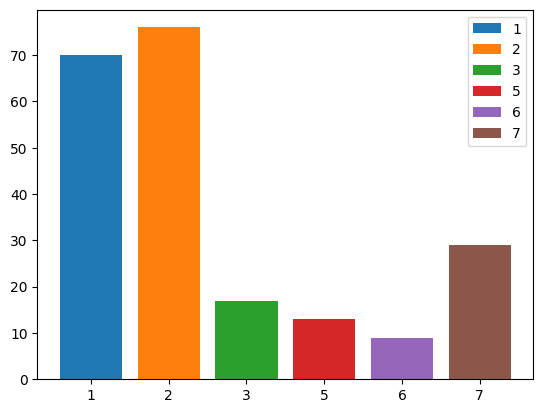

In [12]:
# (4) target countplot

label = pd.unique(df['target'])

for feature in label :
    plt.bar(str(feature), 
            len(df[df['target'] == feature]), label=str(feature))

plt.legend()
plt.show()

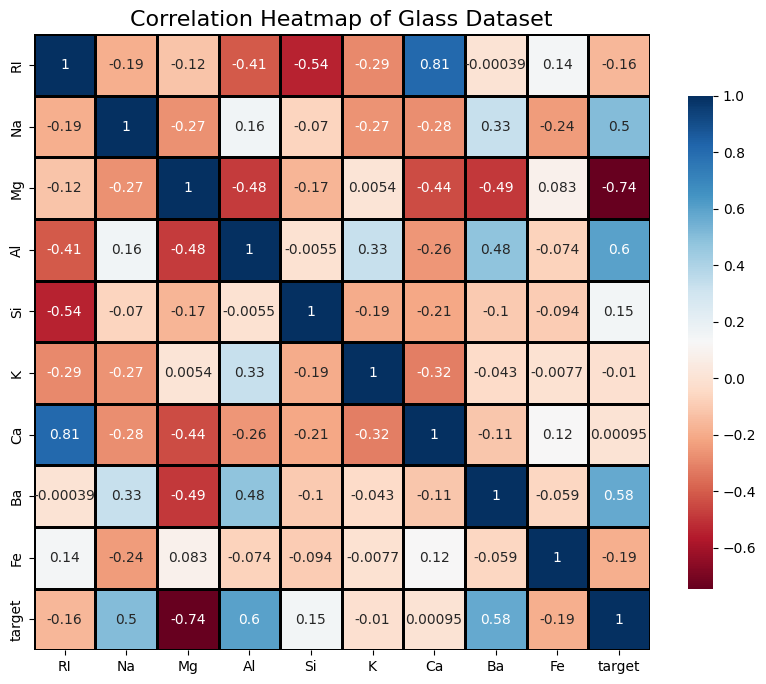

In [13]:
# (5) heatmap

# id 열은 제외
correlation_matrix = df[['RI', 'Na', 'Mg', 
                         'Al', 'Si', 'K', 
                         'Ca', 'Ba', 'Fe', 'target']].corr() 
plt.figure(figsize=(10, 8)) 
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', square=True,
            linewidths=1, linecolor='black', cbar_kws={"shrink": 0.8})

plt.title('Correlation Heatmap of Glass Dataset', fontsize=16)
plt.show()

target을 Mg로 설정한다고 가정했을 때, Mg와 correlation의 절댓값이 높은 feature는 **Al, Ba, Ca** 이다. 자세한 상황은 아래와 같다.

- Mg는 Al과 **상당히** 높은 음의 상관관계 (-0.48)을 가진다.
- 또한, Ba와고도 높은 음의 상관관계 (-0.49)를 가진다. 
- Ca와도 **상당한** 음의 상관관계(-0.44)를 가진다. 

여기서 말하는 **상당하다**의 기준은, 다른 feature들 사이의 correlation 중에서 상대적으로 높다는 것을 의미한다. 사실은 0.4~0.5는 상관관계가 높다고 말할 수 없다고 본다. (상대적인 관점이라는 것을 강조한다.)

결국엔 **Al, Ba, Ca attributes를 feature**로, **Mg를 label(target)** 으로 삼아 regression을 진행한다. feature의 수가 너무 적어 학습이 제대로 되지 않을 수 있기 때문에 feature를 늘리는 방식을 고려해본다.

In [14]:
# (6) feature, input data split

glass_input = df[['Al', 'Ba', 'Ca']].to_numpy()
glass_target = df['Mg'].to_numpy()

glass_input.shape, glass_target.shape

((214, 3), (214,))

In [17]:
# (7) train set, test set, validation set split

# X_train, y_train, X_test, y_test
X_train, X_test, y_train, y_test = train_test_split(glass_input, 
                                                   glass_target,
                                                   test_size=0.2)

# X_train, y_train, X_test, y_test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                 test_size=0.2)

In [18]:
# (8) input data : PolynormialFeature 

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=5) # 5차까지
poly.fit(X_train)

X_train_poly = poly.transform (X_train)
X_test_poly = poly.transform (X_test)
X_val_poly = poly.transform (X_val )

print (f"shape | X_train_poly : {X_train_poly.shape}, X_test_poly : {X_test_poly.shape}, X_val_poly : {X_val_poly.shape}")
print (f"poly | {poly.get_feature_names_out()}")

shape | X_train_poly : (136, 56), X_test_poly : (43, 56), X_val_poly : (35, 56)
poly | ['1' 'x0' 'x1' 'x2' 'x0^2' 'x0 x1' 'x0 x2' 'x1^2' 'x1 x2' 'x2^2' 'x0^3'
 'x0^2 x1' 'x0^2 x2' 'x0 x1^2' 'x0 x1 x2' 'x0 x2^2' 'x1^3' 'x1^2 x2'
 'x1 x2^2' 'x2^3' 'x0^4' 'x0^3 x1' 'x0^3 x2' 'x0^2 x1^2' 'x0^2 x1 x2'
 'x0^2 x2^2' 'x0 x1^3' 'x0 x1^2 x2' 'x0 x1 x2^2' 'x0 x2^3' 'x1^4'
 'x1^3 x2' 'x1^2 x2^2' 'x1 x2^3' 'x2^4' 'x0^5' 'x0^4 x1' 'x0^4 x2'
 'x0^3 x1^2' 'x0^3 x1 x2' 'x0^3 x2^2' 'x0^2 x1^3' 'x0^2 x1^2 x2'
 'x0^2 x1 x2^2' 'x0^2 x2^3' 'x0 x1^4' 'x0 x1^3 x2' 'x0 x1^2 x2^2'
 'x0 x1 x2^3' 'x0 x2^4' 'x1^5' 'x1^4 x2' 'x1^3 x2^2' 'x1^2 x2^3' 'x1 x2^4'
 'x2^5']


In [19]:
# (9) scaling

ss_transformer = StandardScaler()
ss_transformer.fit(X_train_poly)

X_train_poly_scaled = ss_transformer.transform(X_train_poly)
X_test_poly_scaled = ss_transformer.transform(X_test_poly)
X_val_poly_scaled = ss_transformer.transform(X_val_poly)